In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import cv2
import tensorflow as tf
import pathlib
from pathlib import Path
import random
import shutil
import zipfile
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
# Define the dataset directory
dataset_dir = Path('Rice_Image_Dataset')

# Get the class names (subdirectories)
classes = [d.name for d in dataset_dir.iterdir() if d.is_dir()]
num_classes = len(classes)

# Count the images
image_count = sum(len(list((dataset_dir / class_name).glob('*.jpg'))) for class_name in classes)

print(f'Total images: {image_count}')
print(f"Number of classes: {num_classes}")
print("Classes:", classes)

Total images: 75000
Number of classes: 5
Classes: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


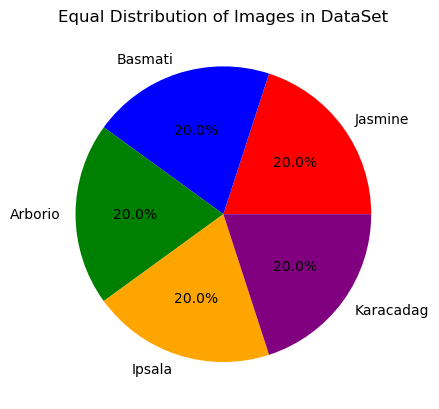

In [9]:
num_classes = 5

images_per_class = [20] * num_classes  


all_classes = ['Jasmine', 'Basmati', 'Arborio', 'Ipsala', 'Karacadag']  #


colors = ['red', 'blue', 'green', 'orange', 'purple']

# Create pie chart
plt.pie(images_per_class, labels=all_classes, autopct='%1.1f%%', colors=colors)
plt.title('Equal Distribution of Images in DataSet')
plt.show()

Load images for different rice types

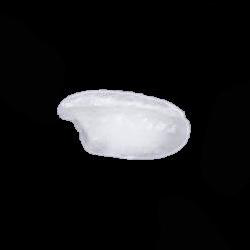

In [13]:
Arborio = list(dataset_dir.glob('Arborio/*'))
PIL.Image.open(str(Arborio[0]))

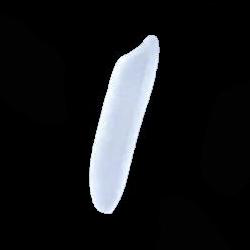

In [15]:
Basmati = list(dataset_dir.glob('Basmati/*'))
PIL.Image.open(str(Basmati[0]))

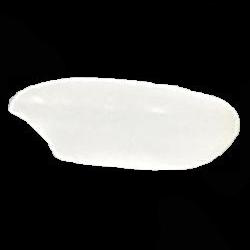

In [17]:
Ipsala = list(dataset_dir.glob('Ipsala/*'))
PIL.Image.open(str(Ipsala[0]))

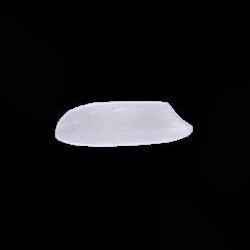

In [19]:
Jasmine = list(dataset_dir.glob('Jasmine/*'))
PIL.Image.open(str(Jasmine[0]))

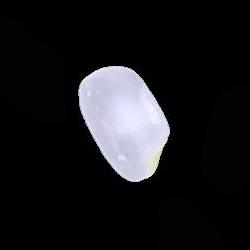

In [21]:
Karacadag = list(dataset_dir.glob('Karacadag/*'))
PIL.Image.open(str(Karacadag[0]))

Making a dictionary

In [24]:
# Count the number of images in the dataset
image_count = len(list(dataset_dir.glob('*/*.jpg')))
print(f"Total images: {image_count}")

# Create a dictionary for all rice images
rice_images_dict = {
    'Arborio': list(dataset_dir.glob('Arborio/*')),
    'Basmati': list(dataset_dir.glob('Basmati/*')),
    'Ipsala': list(dataset_dir.glob('Ipsala/*')),
    'Jasmine': list(dataset_dir.glob('Jasmine/*')),
    'Karacadag': list(dataset_dir.glob('Karacadag/*')),
}

# Create a dictionary for all rice labels
rice_labels_dict = {
    'Arborio': 0,
    'Basmati': 1,
    'Ipsala': 2,
    'Jasmine': 3,
    'Karacadag': 4,
}

Total images: 75000


Prepare features and labels

In [31]:
X, y = [], []
for kind, images in rice_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (80, 80))
        X.append(resized_img)
        y.append(rice_labels_dict[kind])

X = np.array(X)
y = np.array(y)

Split the data

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the sizes of each set
print(f"Training set size: {len(X_train)} ({len(X_train) / len(X) * 100:.2f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val) / len(X) * 100:.2f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test) / len(X) * 100:.2f}%)")

Training set size: 52500 (70.00%)
Validation set size: 11250 (15.00%)
Test set size: 11250 (15.00%)


Normalization

In [39]:
X_train_scaled = X_train / 255.0
X_val_scaled = X_val / 255.0
X_test_scaled = X_test / 255.0

Data Augmentation

In [42]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

CNN Model

In [45]:
def create_model(conv_layers, dense_units, dropout_rate, num_classes):
    model = Sequential()
    for i in range(conv_layers):
        filters = 32 * (2 ** i)
        model.add(layers.Conv2D(filters, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
        model.add(layers.MaxPooling2D())
    
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    return model

# Number of classes
num_classes = 5

In [47]:
# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [49]:
# Create the model
model1 = create_model(conv_layers=5, dense_units=256, dropout_rate=0.3, num_classes=num_classes)

In [51]:
print(X_train_scaled.shape, y_train.shape)
print(X_val_scaled.shape, y_val.shape)

(52500, 80, 80, 3) (52500,)
(11250, 80, 80, 3) (11250,)


In [55]:
# Training the  CNN model with data augmentation
history = model1.fit(
    data_gen.flow(X_train_scaled, y_train, batch_size=32),
    validation_data=(X_val_scaled, y_val),
    epochs=5,
     callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 376s 228ms/step - accuracy: 0.9886 - loss: 0.0686 - val_accuracy: 0.9581 - val_loss: 0.1535 - learning_rate: 5.0000e-04
Epoch 2/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 330s 201ms/step - accuracy: 0.9902 - loss: 0.0600 - val_accuracy: 0.9794 - val_loss: 0.0885 - learning_rate: 5.0000e-04
Epoch 3/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 332s 202ms/step - accuracy: 0.9909 - loss: 0.0577 - val_accuracy: 0.9817 - val_loss: 0.0864 - learning_rate: 5.0000e-04
Epoch 4/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 331s 202ms/step - accuracy: 0.9909 - loss: 0.0559 - val_accuracy: 0.9872 - val_loss: 0.0665 - learning_rate: 5.0000e-04
Epoch 5/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 315s 192ms/step - accuracy: 0.9915 - loss: 0.0516 - val_accuracy: 0.9895 - val_loss: 0.0562 - learning_rate: 5.0000e-04


Evaluate the model

In [58]:
evaluation = model1.evaluate(X_val_scaled, y_val)
print(f"Validation Accuracy: {evaluation[1]}")

352/352 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.9899 - loss: 0.0536
Validation Accuracy: 0.9895111322402954


Predictions

In [61]:
predictions = model1.predict(X_val_scaled)

352/352 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step


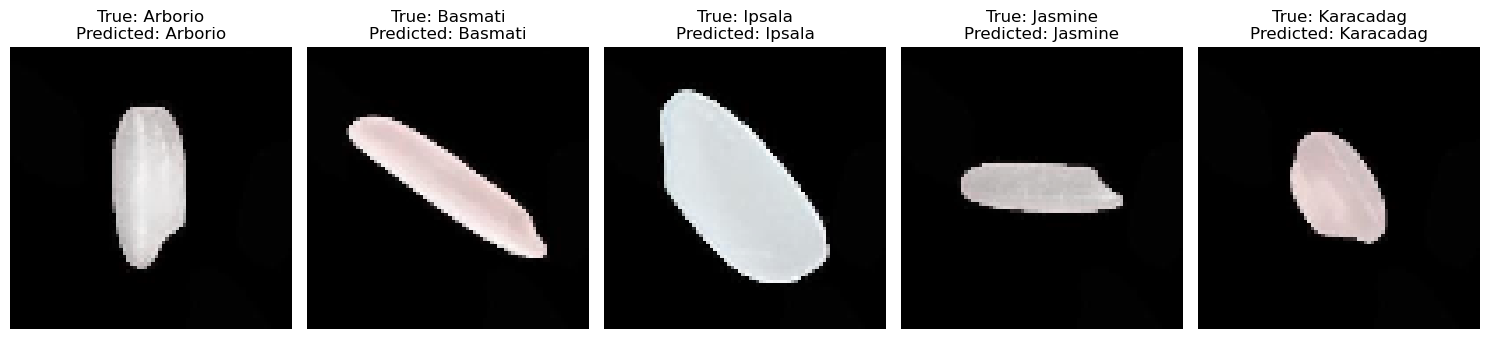

In [63]:
# Plotting Random Images with Predicted and True Class
label_to_class = {idx: category for category, idx in rice_labels_dict.items()}
num_images_to_display = 5  # Display 5 images for 5 types of rice
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))
axes = axes.flatten()

# Selecting randomly from each class
for i, (label, class_index) in enumerate(rice_labels_dict.items()):
    class_indices = np.where(y_val == class_index)[0]  # Find indices corresponding to each class
    random_index = np.random.choice(class_indices)  # Randomly select from the indices
    image = X_val_scaled[random_index]
    true_label = y_val[random_index]
    predicted_label = np.argmax(predictions[random_index])
    
    axes[i].imshow(image)
    axes[i].set_title(f"True: {label_to_class[true_label]}\nPredicted: {label_to_class[predicted_label]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

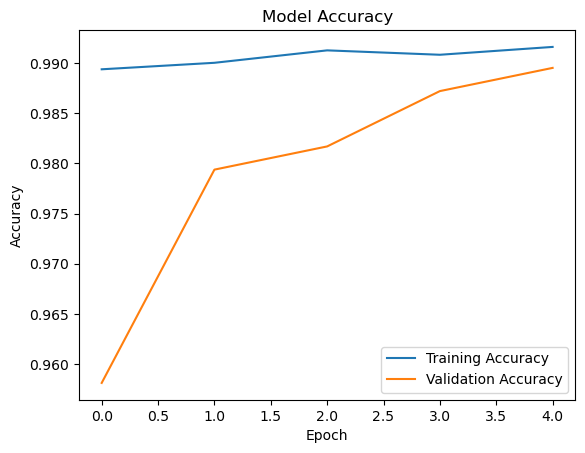

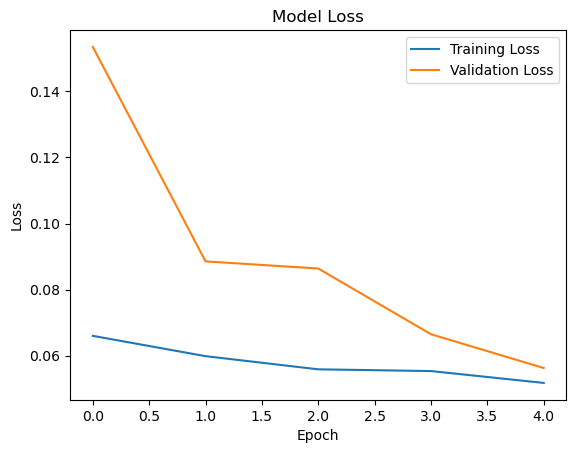

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2243
           1       1.00      0.98      0.99      2248
           2       0.99      1.00      1.00      2282
           3       0.98      0.98      0.98      2217
           4       1.00      0.99      0.99      2260

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250



In [65]:
# Plot Training & Validation Accuracy and Loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Classification Report
y_pred = np.argmax(predictions, axis=1)
print(classification_report(y_val, y_pred))


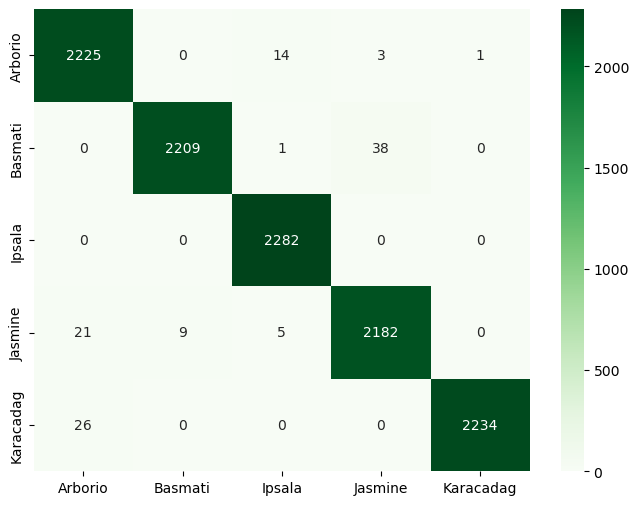

In [67]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=label_to_class.values(), yticklabels=label_to_class.values())
plt.show()

Test Data

In [70]:
evaluation_test = model1.evaluate(X_test_scaled, y_test)
print(f"Testing Accuracy: {evaluation_test[1]}")

predictions_test = model1.predict(X_test_scaled)
y_pred_test = np.argmax(predictions_test, axis=1)
print(classification_report(y_test, y_pred_test))

352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - accuracy: 0.9879 - loss: 0.0638
Testing Accuracy: 0.9873777627944946
352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2229
           1       1.00      0.97      0.98      2227
           2       0.99      1.00      0.99      2368
           3       0.97      0.99      0.98      2261
           4       1.00      0.99      0.99      2165

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250



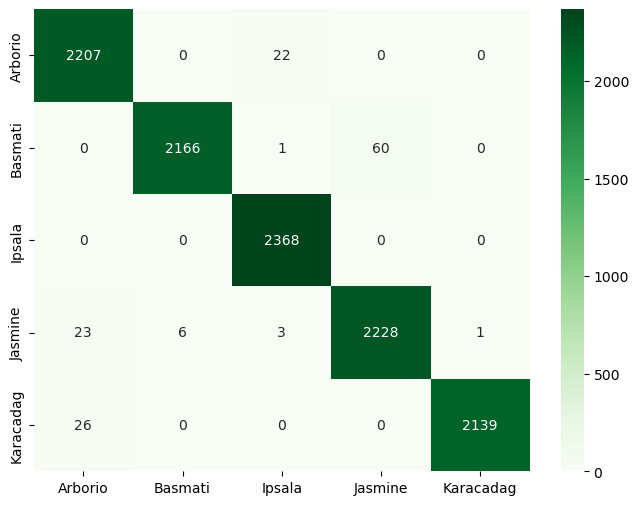

In [72]:
# Confusion Matrix for Test Data
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', xticklabels=label_to_class.values(), yticklabels=label_to_class.values())
plt.show()